# 📈 Basic Portfolio Optimisation

## 1. Get The Data
- Using `yfinance` API and the close proces for the tickers

In [12]:
import yfinance as yf
from datetime import datetime, timedelta
from typing import Final

In [13]:
END_DATE = datetime.today()
DAYS_IN_A_YEAR = 365
NUMBER_OF_YEARS = 5
START_DATE = END_DATE - timedelta(days = NUMBER_OF_YEARS * DAYS_IN_A_YEAR)

TICKERS: Final[list[str]] = ['AAPL', 'MSFT', 'SPY', 'GLD']

data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)['Close']
data.head()

Ticker,AAPL,GLD,MSFT,SPY
Date,,,,
2020-10-23,111.901474,178.639999,207.326843,322.357086
2020-10-26,111.911179,178.550003,201.430054,316.399994
2020-10-27,113.418884,179.020004,204.469498,315.309204
2020-10-28,108.166222,176.130005,194.334686,304.532288
2020-10-29,112.173820,175.399994,196.290756,307.627441


## 2. Analyse the Data
- Obtain the log returns and visualise the distibution in histograms
- Assess the Covariance for the financial instruments

In [14]:
import numpy as np

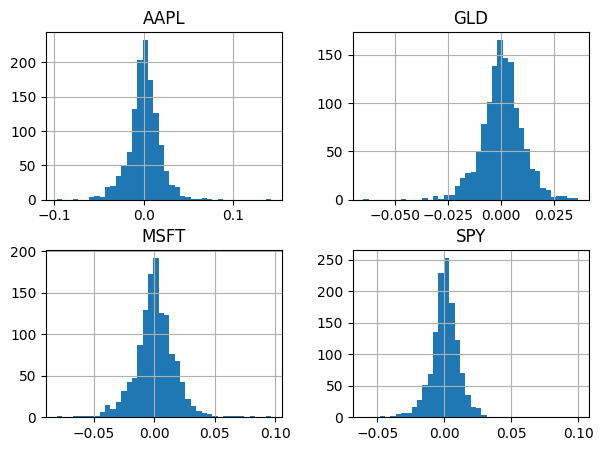

In [19]:
returns = np.log(data / data.shift(1))
returns.hist(bins=40, figsize=(7, 5));

In [24]:
# Annualised mean returns
returns.mean() * 252

Ticker
AAPL    0.171686
GLD     0.150651
MSFT    0.184027
SPY     0.147510
dtype: float64

In [25]:
# Annualised covariance matrix
returns.cov() * 252

Ticker,AAPL,GLD,MSFT,SPY
Ticker,,,,
AAPL,0.080591,0.003692,0.047264,0.036947
GLD,0.003692,0.024235,0.003353,0.003255
MSFT,0.047264,0.003353,0.067090,0.034008
SPY,0.036947,0.003255,0.034008,0.029687


## 3. Basic Theory

- It's assumed that the investor is not allowed to have short positions in a financial instrument (onloy long positions allowed)
- 100% of investors wealth has to be divided up among the availabole financial instruments

In [28]:
# Create 4 (number of tickers) random weights that sum to 1.0 
weights = np.random.random(len(TICKERS))
weights /= np.sum(weights)
weights

array([0.40524828, 0.04463906, 0.41618802, 0.13392465])

In [29]:
weights.sum()

np.float64(1.0)

In [30]:
# The expected portfolio returns taking the historical mean perfromance of each instrument and random weights
np.sum(returns.mean() * weights) * 252

np.float64(0.1726452896938126)

In [33]:
# Annualised portfolio variance given the portfolio weights
var = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
var

np.float64(0.0494781252658987)

In [36]:
# Annualised portfolio volatility given the portfolio weights
import math
np.sqrt(var)

np.float64(0.2224367893714947)

## 4. Monte Carlo Simulation of Expected Returns and Volatility

In [39]:
from numpy.typing import NDArray

def get_portfolio_returns(weights: NDArray[np.float64]) -> np.float64:
    return np.sum(returns.mean() * weights) * 252

def get_portfolio_volatility(weights: NDArray[np.float64]) -> np.float64:
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def create_random_weights(num_weights: int) -> NDArray[np.float64]:
    weights = np.random.random(num_weights)
    weights /= np.sum(weights)
    return weights

portfolio_rets = []
portfolio_vols = []

I = 2500 # number of simulations
for p in range(I):
    weights = create_random_weights(len(TICKERS))
    portfolio_rets.append(get_portfolio_returns(weights))
    portfolio_vols.append(get_portfolio_volatility(weights))

portfolio_rets = np.array(portfolio_rets)
portfolio_vols = np.array(portfolio_vols)

In [40]:
from pylab import mpl, plt

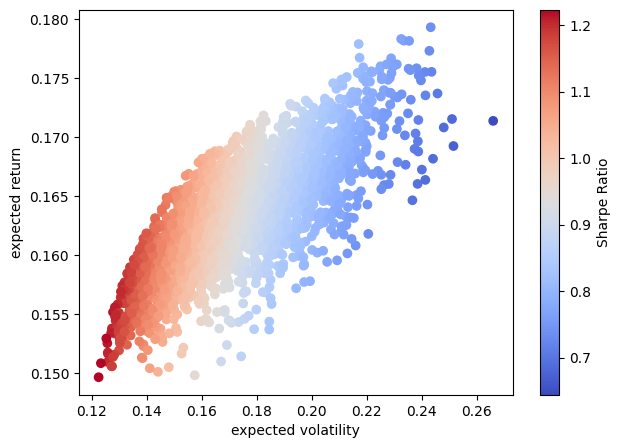

In [41]:
plt.figure(figsize=(7, 5))
plt.scatter(
    portfolio_vols,
    portfolio_rets,
    c=portfolio_rets/portfolio_vols,
    marker='o',
    cmap='coolwarm'
)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe Ratio');

## 5. Optimal Portfolio
- Using a minimisation function to find the optimal portfolio weights given constraints
- Maximisation of sharpe ratio is used to derive the maximum value and the optimal portfolio composition.

In [43]:
import scipy.optimize as sco

In [44]:
def min_func_sharpe(weights: NDArray[np.float64]) -> np.float64:
    '''
    Function to be minimised.
    
    Formally the negative value of the sharpe ratio is minimised to derive the maximum
    value and the optimal portfolio composition
    '''
    return -get_portfolio_returns(weights) / get_portfolio_volatility(weights)

# Constraints
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(len(TICKERS)))
equal_weights = np.array(len(TICKERS) * [1. / len(TICKERS)])
equal_weights

array([0.25, 0.25, 0.25, 0.25])

In [45]:
min_func_sharpe(equal_weights)

np.float64(-0.9655112322055625)

### Maximum Sharpe Ratio Portfolio (MSRP)
- Maximise risk-adjusted return, measured by the Sharpe ratio
- Balances expected return and risk to get the best return per unit of volatility.
- Depends on both expected returns and covariance matrix
- Lies tangentially to the efficient frontier from the risk-free rate (called the tangency portfolio).


In [46]:
opts = sco.minimize(min_func_sharpe, equal_weights, method='SLSQP', bounds=bnds, constraints=cons)
opts

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -1.22506027007994
           x: [ 0.000e+00  5.694e-01  6.172e-02  3.689e-01]
         nit: 6
         jac: [ 1.051e-01 -5.589e-04  1.031e-03  6.901e-04]
        nfev: 30
        njev: 6
 multipliers: [ 5.563e-06]

In [47]:
# Optimal portfolio weights
opts['x'].round(3)

array([0.   , 0.569, 0.062, 0.369])

In [49]:
# Optimal portfolio return
get_portfolio_returns(opts['x']).round(3)

np.float64(0.152)

In [50]:
# Optimal portfolio volatility
get_portfolio_volatility(opts['x']).round(3)

np.float64(0.124)

In [51]:
# Share Ratio
get_portfolio_returns(opts['x']) / get_portfolio_volatility(opts['x'])

np.float64(1.22506027007994)

### Minimum Volatility Portfolio (MVP)
- Minimise the portfolio’s total risk (volatility), regardless of expected return.
- Focuses purely on risk minimisation.
- The MVP is the point on the efficient frontier with the lowest variance.
- It does not consider expected returns — only covariances (the structure of risk).
- Often dominated by low-volatility assets (like bonds or defensives)

In [54]:
# get the minimum variance portfolio 
optv = sco.minimize(get_portfolio_volatility, equal_weights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.12227618610624652
           x: [ 0.000e+00  5.560e-01  3.882e-18  4.440e-01]
         nit: 8
         jac: [ 1.509e-01  1.220e-01  1.387e-01  1.226e-01]
        nfev: 40
        njev: 8
 multipliers: [ 1.223e-01]

In [56]:
# Optimal portfolio weights
optv['x'].round(3)

array([0.   , 0.556, 0.   , 0.444])

In [57]:
# Optimal portfolio return
get_portfolio_returns(optv['x']).round(3)

np.float64(0.149)

In [58]:
# Optimal portfolio volatility
get_portfolio_volatility(optv['x']).round(3)

np.float64(0.122)

In [59]:
# Share Ratio
get_portfolio_returns(optv['x']) / get_portfolio_volatility(optv['x'])

np.float64(1.2206515297074894)